# Obligatorio - Machine Learning
# 1. Importación de librerías
# 2. Preprocesamiento de datos
# 3. Análisis exploratorio
# 4. Entrenamiento de modelos
# 5. Evaluación de modelos
# 6. Exportación de predicciones

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, classification_report, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats.mstats import winsorize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

df_train = pd.read_csv('./dataset/train.csv')
df_test = pd.read_csv('./dataset/test.csv')

# Funciones Auxiliares

In [72]:
# Paso 1: Rellenar valores faltantes
def clean_data(df):
    # Completar valores faltantes
    df['Year'] = df['Year'].fillna(df['Year'].median())  # Completar con la mediana
    df['Publisher'] = df['Publisher'].fillna('Unknown')  # Completar con "Unknown"

    # Eliminar columnas irrelevantes
    if 'Summary' in df.columns:
        df = df.drop(columns=['Summary'])

    return df

# Paso 2: Convertir columnas numéricas con valores inconsistentes
def convert_to_numeric(value):
    """
    Convierte valores como '1.2K' en valores numéricos.
    """
    value_str = str(value)
    if 'K' in value_str:
        return float(value_str.replace('K', '')) * 1000
    try:
        return float(value_str)
    except ValueError:
        return 0.0

# Paso 3: Manejar outliers
def handle_outliers(df, columns):
    """
    Aplica winsorización para manejar valores extremos en las columnas especificadas.
    """
    for col in columns:
        df[col] = winsorize(df[col], limits=[0.01, 0.01])  # Recorta 1% inferior y superior
    return df

# Paso 4: Codificar variables categóricas
def encode_categorical(df, categorical_columns):
    label_encoder = LabelEncoder()
    for col in categorical_columns:
        if col in df.columns:
            df[col] = label_encoder.fit_transform(df[col])
    return df

# Paso 5: Escalar columnas numéricas
def scale_numerical(df, numerical_columns):
    scaler = StandardScaler()
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])
    return df

# Paso 6: Rellenar valores faltantes en `Genre` usando `Summary`
def fill_missing_genres(df):
    """
    Rellena los valores faltantes de la columna `Genre` basándose en la columna `Summary`.
    Utiliza un modelo de clasificación de texto.
    """
    # Separar filas con y sin `Genre`
    df_with_genre = df[df['Genre'].notnull()]
    df_missing_genre = df[df['Genre'].isnull()]

    if len(df_missing_genre) > 0:
        # Convertir valores categóricos de `Genre` a números
        label_encoder = LabelEncoder()
        df_with_genre['Genre'] = label_encoder.fit_transform(df_with_genre['Genre'])

        # Modelo de clasificación de texto
        text_clf = Pipeline([
            ('tfidf', TfidfVectorizer(stop_words='english', max_features=1000)),
            ('clf', LogisticRegression(max_iter=1000, random_state=42))
        ])

        # Entrenar el modelo con los datos disponibles
        text_clf.fit(df_with_genre['Summary'], df_with_genre['Genre'])

        # Predecir los géneros faltantes
        predicted_genres = text_clf.predict(df_missing_genre['Summary'])

        # Convertir las predicciones de vuelta a etiquetas originales
        df_missing_genre['Genre'] = label_encoder.inverse_transform(predicted_genres)

        # Combinar las filas con `Genre` y las predichas
        df = pd.concat([df_with_genre, df_missing_genre])

    return df

# Paso 7: Crear nuevas columnas derivadas
def create_new_columns(df):
    """
    Crea nuevas columnas derivadas basadas en la información existente.
    """
    df['Game_Age'] = 2024 - df['Year']
    
    # Ratios regionales
    df['NorthAmerica_Global_Ratio'] = df['North America'] / df['Global']
    df['Europe_Global_Ratio'] = df['Europe'] / df['Global']
    df['Japan_Global_Ratio'] = df['Japan'] / df['Global']
    df['RestOfWorld_Global_Ratio'] = df['Rest of World'] / df['Global']

    # Relación entre reseñas y wishlist
    df['Reviews_Wishlist_Ratio'] = df['Number of Reviews'] / df['Wishlist']

    # Interacciones categóricas
    df['Publisher_Platform_Interaction'] = df['Publisher'] + df['Platform']

    return df


# Preprocesamiento de los datos

In [73]:
def preprocess_data_with_genre_and_columns(df):
    # Limpiar datos
    df = clean_data(df)

    # Rellenar valores faltantes en `Genre` usando `Summary`
    if 'Summary' in df.columns and 'Genre' in df.columns:
        df = fill_missing_genres(df)

    # Convertir columnas numéricas con valores inconsistentes
    columns_to_convert = ['Europe', 'Japan', 'Rest of World', 'North America', 
                          'Global', 'Number of Reviews', 'Wishlist']
    for col in columns_to_convert:
        if col in df.columns:
            df[col] = df[col].apply(convert_to_numeric)

    # Manejar outliers
    outlier_columns = ['Global', 'Wishlist']
    df = handle_outliers(df, outlier_columns)

    # Codificar columnas categóricas
    categorical_columns = ['Game Title', 'Publisher', 'Platform', 'Genre']
    df = encode_categorical(df, categorical_columns)

    # Crear nuevas columnas derivadas
    df = create_new_columns(df)

    # Escalar columnas numéricas
    numerical_columns = ['North America', 'Europe', 'Japan', 'Rest of World', 
                         'Global', 'Number of Reviews', 'Wishlist', 'Game_Age', 
                         'Europe_Global_Ratio', 'Japan_Global_Ratio', 
                         'NorthAmerica_Global_Ratio', 'RestOfWorld_Global_Ratio',
                         'Reviews_Wishlist_Ratio']
    df = scale_numerical(df, numerical_columns)

    # Eliminar columnas irrelevantes
    columns_to_drop = ['Game Title']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

    # Eliminar las columnas regionales originales después de crear los ratios
    columns_to_drop = ['North America', 'Europe', 'Japan', 'Rest of World']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

    return df

# Aplicar el preprocesamiento actualizado
df_train = preprocess_data_with_genre_and_columns(df_train)
df_test = preprocess_data_with_genre_and_columns(df_test)

# Verificar el resultado
print("Datos preprocesados con géneros rellenados y nuevas columnas (train):")
print(df_train.head())

Datos preprocesados con géneros rellenados y nuevas columnas (train):
   id    Year  Publisher    Global  Number of Reviews  Wishlist  Platform  \
0   1  2007.0        500 -0.340005           0.839035  1.359185         0   
1   2  2007.0        500 -0.340005           2.496069 -0.326198         0   
2   3  2007.0        500 -0.340005           0.878488  1.385937         0   
3   4  1987.0        337  4.952858           2.658265  0.786689        10   
4   5  2007.0        500 -0.340005           2.719637  3.360243         0   

   Genre    Rating  Game_Age  NorthAmerica_Global_Ratio  Europe_Global_Ratio  \
0     11  7.345609 -0.220206                   0.125542            -0.340306   
1     13  6.511195 -0.220206                   0.125542            -0.340306   
2     13  6.651093 -0.220206                   0.125542            -0.340306   
3      1  7.900000  3.204727                   0.210322            -0.354835   
4      1  7.152074 -0.220206                   0.125542            

In [74]:
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Función para evaluar correlación con la variable objetivo (para regresión)
def evaluate_feature_correlation(X, y):
    """
    Evalúa la correlación de cada característica con la variable objetivo.
    Devuelve un DataFrame con las puntuaciones.
    """
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(X, y)
    scores = selector.scores_

    # Crear un DataFrame con las puntuaciones
    feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
    feature_scores = feature_scores.sort_values(by='Score', ascending=False)

    print("Importancia de características basada en correlación:")
    print(feature_scores)
    return feature_scores

# Función para evaluar la importancia de características usando un modelo
def evaluate_feature_importance_model(X, y):
    """
    Evalúa la importancia de características utilizando un RandomForestRegressor.
    Devuelve un DataFrame con las importancias.
    """
    model = RandomForestRegressor(random_state=42)
    model.fit(X, y)
    importances = model.feature_importances_

    # Crear un DataFrame con las importancias
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    # Visualizar la importancia de características
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances['Feature'], feature_importances['Importance'])
    plt.xlabel("Importancia")
    plt.ylabel("Características")
    plt.title("Importancia de características según RandomForest")
    plt.gca().invert_yaxis()
    plt.show()

    print("Importancia de características basada en RandomForest:")
    print(feature_importances)
    return feature_importances

# Selección de las características más relevantes
def select_top_features(X, y, k=10):
    """
    Selecciona las k características más relevantes utilizando SelectKBest.
    """
    selector = SelectKBest(score_func=f_regression, k=k)
    X_selected = selector.fit_transform(X, y)

    # Obtener las columnas seleccionadas
    selected_columns = X.columns[selector.get_support()]
    print(f"Características seleccionadas ({k} mejores): {selected_columns}")
    return X_selected, selected_columns

# Aplicar evaluación y selección de características
X = df_train.drop(columns=['Rating'])  # Variables predictoras
y = df_train['Rating']  # Variable objetivo

# 1. Evaluar correlación con la variable objetivo
correlation_scores = evaluate_feature_correlation(X, y)

# 2. Evaluar importancia de características usando RandomForest
importance_scores = evaluate_feature_importance_model(X, y)

# 3. Seleccionar las k características más relevantes
X_selected, selected_columns = select_top_features(X, y, k=10)

# Actualizar el dataset con las características seleccionadas
df_train_selected = pd.DataFrame(X_selected, columns=selected_columns)
df_train_selected['Rating'] = y  # Añadir la columna objetivo para usar en el modelo

Importancia de características basada en correlación:
                           Feature        Score
3                           Global  6405.992197
12        RestOfWorld_Global_Ratio   583.919107
9        NorthAmerica_Global_Ratio   365.169610
7                            Genre   311.619155
11              Japan_Global_Ratio   297.402654
10             Europe_Global_Ratio   180.030086
6                         Platform    97.097748
13          Reviews_Wishlist_Ratio    83.682834
4                Number of Reviews    44.871705
1                             Year    19.721526
8                         Game_Age    19.721526
0                               id    15.409472
5                         Wishlist     9.157735
14  Publisher_Platform_Interaction     1.847696
2                        Publisher     0.734464


KeyboardInterrupt: 

In [ ]:
def preprocess_data_optimized(df):

    # Eliminar columnas menos relevantes
    columns_to_drop = ['id', 'Publisher_Platform_Interaction', 'Publisher', 'Wishlist', 
                       'Number of Reviews', 'Reviews_Wishlist_Ratio']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

    return df

# Aplicar el preprocesamiento optimizado
df_train = preprocess_data_optimized(df_train)
df_test = preprocess_data_optimized(df_test)

# Verificar el resultado
print("Datos preprocesados optimizados (train):")
print(df_train.head())

Datos preprocesados optimizados (train):
     Year    Global  Platform  Genre    Rating  Game_Age  \
0  2007.0 -0.340005         0     11  7.345609 -0.220206   
1  2007.0 -0.340005         0     13  6.511195 -0.220206   
2  2007.0 -0.340005         0     13  6.651093 -0.220206   
3  1987.0  4.952858        10      1  7.900000  3.204727   
4  2007.0 -0.340005         0      1  7.152074 -0.220206   

   NorthAmerica_Global_Ratio  Europe_Global_Ratio  Japan_Global_Ratio  \
0                   0.125542            -0.340306           -0.674588   
1                   0.125542            -0.340306           -0.674588   
2                   0.125542            -0.340306           -0.674588   
3                   0.210322            -0.354835            0.188184   
4                   0.125542            -0.340306           -0.674588   

   RestOfWorld_Global_Ratio  
0                 -0.003338  
1                 -0.003338  
2                 -0.003338  
3                 -0.552807  
4        

Importancia de características basada en correlación:
                     Feature        Score
1                     Global  6405.992197
8   RestOfWorld_Global_Ratio   583.919107
5  NorthAmerica_Global_Ratio   365.169610
3                      Genre   311.619155
7         Japan_Global_Ratio   297.402654
6        Europe_Global_Ratio   180.030086
2                   Platform    97.097748
0                       Year    19.721526
4                   Game_Age    19.721526


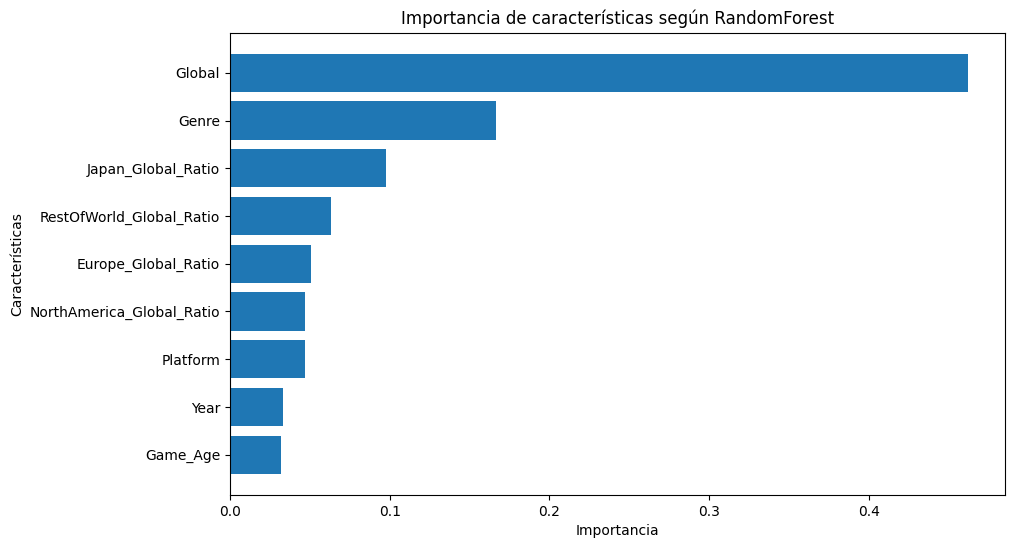

Importancia de características basada en RandomForest:
                     Feature  Importance
1                     Global    0.462097
3                      Genre    0.166335
7         Japan_Global_Ratio    0.097846
8   RestOfWorld_Global_Ratio    0.063528
6        Europe_Global_Ratio    0.050548
5  NorthAmerica_Global_Ratio    0.047305
2                   Platform    0.047240
0                       Year    0.033122
4                   Game_Age    0.031979
Características seleccionadas (10 mejores): Index(['Year', 'Global', 'Platform', 'Genre', 'Game_Age',
       'NorthAmerica_Global_Ratio', 'Europe_Global_Ratio',
       'Japan_Global_Ratio', 'RestOfWorld_Global_Ratio'],
      dtype='object')


/Users/spark/Library/Python/3.9/lib/python/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=9. All the features will be returned.
  warnings.warn(


In [ ]:
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Función para evaluar correlación con la variable objetivo (para regresión)
def evaluate_feature_correlation(X, y):
    """
    Evalúa la correlación de cada característica con la variable objetivo.
    Devuelve un DataFrame con las puntuaciones.
    """
    selector = SelectKBest(score_func=f_regression, k='all')
    selector.fit(X, y)
    scores = selector.scores_

    # Crear un DataFrame con las puntuaciones
    feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
    feature_scores = feature_scores.sort_values(by='Score', ascending=False)

    print("Importancia de características basada en correlación:")
    print(feature_scores)
    return feature_scores

# Función para evaluar la importancia de características usando un modelo
def evaluate_feature_importance_model(X, y):
    """
    Evalúa la importancia de características utilizando un RandomForestRegressor.
    Devuelve un DataFrame con las importancias.
    """
    model = RandomForestRegressor(random_state=42)
    model.fit(X, y)
    importances = model.feature_importances_

    # Crear un DataFrame con las importancias
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    # Visualizar la importancia de características
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importances['Feature'], feature_importances['Importance'])
    plt.xlabel("Importancia")
    plt.ylabel("Características")
    plt.title("Importancia de características según RandomForest")
    plt.gca().invert_yaxis()
    plt.show()

    print("Importancia de características basada en RandomForest:")
    print(feature_importances)
    return feature_importances

# Selección de las características más relevantes
def select_top_features(X, y, k=10):
    """
    Selecciona las k características más relevantes utilizando SelectKBest.
    """
    selector = SelectKBest(score_func=f_regression, k=k)
    X_selected = selector.fit_transform(X, y)

    # Obtener las columnas seleccionadas
    selected_columns = X.columns[selector.get_support()]
    print(f"Características seleccionadas ({k} mejores): {selected_columns}")
    return X_selected, selected_columns

# Aplicar evaluación y selección de características
X = df_train.drop(columns=['Rating'])  # Variables predictoras
y = df_train['Rating']  # Variable objetivo

# 1. Evaluar correlación con la variable objetivo
correlation_scores = evaluate_feature_correlation(X, y)

# 2. Evaluar importancia de características usando RandomForest
importance_scores = evaluate_feature_importance_model(X, y)

# 3. Seleccionar las k características más relevantes
X_selected, selected_columns = select_top_features(X, y, k=10)

# Actualizar el dataset con las características seleccionadas
df_train_selected = pd.DataFrame(X_selected, columns=selected_columns)
df_train_selected['Rating'] = y  # Añadir la columna objetivo para usar en el modelo

# Modelado

### Funciones Auxiliares

In [ ]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer

# Validación cruzada para cualquier modelo
def perform_cross_validation(model, X, y, scoring='neg_mean_squared_error', cv=5):
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring)
    mse = -scores.mean()  # Negamos para obtener el MSE positivo
    rmse = np.sqrt(mse)
    print(f"Cross-Validation MSE: {mse:.4f}")
    print(f"Cross-Validation RMSE: {rmse:.4f}")

# Optimización de hiperparámetros
def optimize_hyperparameters(model, param_grid, X_train, y_train, scoring='neg_mean_squared_error', cv=5):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=cv, verbose=2)
    grid_search.fit(X_train, y_train)
    print("Best Hyperparameters:", grid_search.best_params_)
    return grid_search.best_estimator_

Regresion Lineal

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
import numpy as np

# Dividir los datos en entrenamiento y prueba
X = df_train_selected.drop(columns=['Rating'])  # Variables predictoras
y = df_train_selected['Rating']  # Variable objetivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Validación cruzada para Regresión Lineal
linear_model = LinearRegression()
perform_cross_validation(linear_model, X, y)

# Entrenar modelo de regresión lineal
linear_model.fit(X_train, y_train)

# Predicciones
y_pred = linear_model.predict(X_test)

# Métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Modelo: Regresión Lineal")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

Cross-Validation MSE: 0.1426
Cross-Validation RMSE: 0.3777
Modelo: Regresión Lineal
MSE: 0.1349
RMSE: 0.3672
R²: 0.4232


Arboles de decision

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Hiperparámetros para optimizar
param_grid_tree = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Optimización con GridSearchCV
optimized_tree_model = optimize_hyperparameters(
    DecisionTreeRegressor(random_state=42),
    param_grid_tree,
    X_train,
    y_train
)

# Predicciones con el mejor modelo
y_pred = optimized_tree_model.predict(X_test)

# Métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModelo: Árbol de Decisión Optimizado")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time=   0.0s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[C

Random Forest

In [79]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Hiperparámetros para optimizar
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# Optimización con GridSearchCV
grid_search_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_rf,
    cv=5,  # Validación cruzada con 5 particiones
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1  # Usa todos los núcleos disponibles
)

# Entrenar el modelo con los datos de entrenamiento
grid_search_rf.fit(X_train, y_train)

# Mejor modelo encontrado
optimized_rf_model = grid_search_rf.best_estimator_
print("Mejores parámetros para Random Forest:", grid_search_rf.best_params_)

# Predicciones con el mejor modelo
y_pred = optimized_rf_model.predict(X_test)

# Métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModelo: Random Forest Optimizado")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Validación cruzada para calcular la desviación estándar del R²
cv_scores = cross_val_score(optimized_rf_model, X_train, y_train, cv=5, scoring='r2')
print("\nValidación cruzada para Random Forest:")
print(f"R² promedio: {cv_scores.mean():.4f}")
print(f"Desviación estándar de R²: {cv_scores.std():.4f}")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Mejores parámetros para Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Modelo: Random Forest Optimizado
MSE: 0.0697
RMSE: 0.2639
R²: 0.7021

Validación cruzada para Random Forest:
R² promedio: 0.7100
Desviación estándar de R²: 0.0238


Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Hiperparámetros para optimizar
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]  # Prueba con una fracción de los datos
}

# Optimización con GridSearchCV
grid_search_gb = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gb,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1  # Usa todos los núcleos disponibles
)

# Entrenar el modelo con los datos de entrenamiento
grid_search_gb.fit(X_train, y_train)

# Mejor modelo encontrado
best_gb_model = grid_search_gb.best_estimator_
print("Mejores parámetros para Gradient Boosting:", grid_search_gb.best_params_)

# Predicciones con el modelo optimizado
y_pred = best_gb_model.predict(X_test)

# Métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModelo: Gradient Boosting Optimizado")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Validación cruzada con el mejor modelo
cv_scores = cross_val_score(best_gb_model, X_train, y_train, cv=5, scoring='r2')
print("\nValidación cruzada para Gradient Boosting:")
print(f"R² promedio: {cv_scores.mean():.4f}")
print(f"Desviación estándar de R²: {cv_scores.std():.4f}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Mejores parámetros para Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.8}

Modelo: Gradient Boosting Optimizado
MSE: 0.0673
RMSE: 0.2595
R²: 0.7120

Validación cruzada para Gradient Boosting:
R² promedio: 0.7134
Desviación estándar de R²: 0.0218


Ada boost

In [83]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Cambiar el estimador base a un árbol de decisión más profundo
base_estimator = DecisionTreeRegressor(random_state=42)

# Hiperparámetros para optimizar
param_grid_ada = {
    'n_estimators': [100, 200, 300],          # Número de árboles en el modelo
    'learning_rate': [0.01, 0.1],  # Tasa de aprendizaje
    'estimator__max_depth': [5, 7, 10],       # Profundidad del estimador base
}

# Optimización con GridSearchCV
grid_search_ada = GridSearchCV(
    AdaBoostRegressor(estimator=base_estimator, random_state=42),
    param_grid_ada,
    cv=5,                                     # Validación cruzada
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1                                 # Paralelización
)

# Entrenar el modelo con los datos escalados
grid_search_ada.fit(X_train_scaled, y_train)

# Mejor modelo encontrado
best_ada_model = grid_search_ada.best_estimator_
print("Mejores parámetros para AdaBoost:", grid_search_ada.best_params_)

# Predicciones con el modelo optimizado
y_pred = best_ada_model.predict(X_test_scaled)

# Métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModelo: AdaBoost Optimizado")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Validación cruzada con el mejor modelo
cv_scores = cross_val_score(best_ada_model, X_train_scaled, y_train, cv=5, scoring='r2')
print("\nValidación cruzada para AdaBoost:")
print(f"R² promedio: {cv_scores.mean():.4f}")
print(f"Desviación estándar de R²: {cv_scores.std():.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Mejores parámetros para AdaBoost: {'estimator__max_depth': 10, 'learning_rate': 0.01, 'n_estimators': 200}

Modelo: AdaBoost Optimizado
MSE: 0.0723
RMSE: 0.2689
R²: 0.6907

Validación cruzada para AdaBoost:
R² promedio: 0.7054
Desviación estándar de R²: 0.0261


Redes Neuronales

In [78]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hiperparámetros para optimizar
param_grid_mlp = {
    'hidden_layer_sizes': [(50, 50), (100, 50)],  # Menos combinaciones
    'activation': ['relu'],                     # Solo el mejor
    'solver': ['adam'],                         # Mantén el mejor
    'alpha': [0.001, 0.01],                     # Foco en valores más altos
    'learning_rate_init': [0.001, 0.01],        # Menos combinaciones
    'max_iter': [500]                           # Mantén constante
}

# Optimización con RandomizedSearchCV
random_search_mlp = RandomizedSearchCV(
    MLPRegressor(random_state=42),
    param_distributions=param_grid_mlp,
    n_iter=20,  # Número de combinaciones a probar
    cv=3,       # Validación cruzada con 3 particiones
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1   # Paralelización
)

# Entrenar el modelo con los datos escalados
random_search_mlp.fit(X_train_scaled, y_train)

# Mejor modelo encontrado
best_mlp_model = random_search_mlp.best_estimator_
print("Mejores parámetros para Redes Neuronales:", random_search_mlp.best_params_)

# Predicciones con el modelo optimizado
y_pred = best_mlp_model.predict(X_test_scaled)

# Métricas
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModelo: Redes Neuronales Optimizado")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Validación cruzada con el mejor modelo
cv_scores = cross_val_score(best_mlp_model, X_train_scaled, y_train, cv=3, scoring='r2')
print("\nValidación cruzada para Redes Neuronales:")
print(f"R² promedio: {cv_scores.mean():.4f}")
print(f"Desviación estándar de R²: {cv_scores.std():.4f}")

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Mejores parámetros para Redes Neuronales: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.001, 'max_iter': 500, 'solver': 'adam'}

Modelo: Redes Neuronales Optimizado
MSE: 0.1010
RMSE: 0.3179
R²: 0.5679

Validación cruzada para Redes Neuronales:
R² promedio: 0.5893
Desviación estándar de R²: 0.0229
